<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_23_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# !!DONE!! no more changes here, there's a lot of meat to this one and I need to use it to generate results for report, can't afford to break it!!

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [3]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 52
-rw------- 1 root root 28586 Aug 18 21:35 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [5]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [6]:
# regular imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

# object that provides colours for charts
from itertools import cycle

# sklearn imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [144]:
from scipy import stats

In [7]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 3.1MB/s 


In [8]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-11-24 13:32:25.454444, module name: stats_n_features
>> LOADING custom module, when: 2020-11-24 13:32:25.455536, module name: data_prep
>> LOADING custom module, when: 2020-11-24 13:32:25.702439, module name: pipeline_utils


In [9]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-11-24 13:32:25.735726,  param:bling
Test function in stats_n_features called and worked! when: 2020-11-24 13:32:25.735927,  param:hello


## Pandas display options

In [10]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [11]:
##################################
######## LOAD

my_data = dp.load_all_data()
all_drummer_data = my_data.copy()
;

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.0: 'High Floor

''

## Single file tests..

In [12]:
##################################
######## EXPLORE SINGLE FILE

# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'

test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()
df1.head()

print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


In [13]:
# pull out notes in named bars...
display(df1.xs(1, level='bar_number')) 
display(df1.xs(2, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,55,7,1
1,kick,64,10,1
3,kick,57,-29,3
3,hh,31,-2,3
5,hh,54,-13,5
5,snare,93,-5,5
7,hh,42,-16,7
8,snare,33,-12,8
10,snare,33,-14,10


,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,42,-7,1
1,kick,55,-5,1
3,kick,62,-10,3
3,hh,41,3,3
5,snare,94,4,5
5,hh,51,5,5
7,hh,45,7,7
8,snare,32,7,8
9,hh,43,2,9


## Filter songs...

Take a look at all file names in the complete data set...

In [130]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

Code to pull out data to test, based on selected songs. Also add 'y' (target/ observation) label.

In [215]:

# FILTER SONGS BEING TESTED, ADD LABEL

def addLabelCol(df, label):
  '''
  Input: data_prep.PerformanceData.tight_df
  Return: df with additional colum for Y/ label called 'drummer_ID'
  '''
  df.insert(0, 'drummer_ID', label) # add it as first col
  return df

def load_songs(style_filter=[]):

  songs_data = []

  if len(style_filter) == 0:
    print('>>>> Loading all songs ...')
    for next_file in all_drummer_data.keys():
      perf_data = all_drummer_data[next_file]
      file_name = perf_data.file_wrapper.my_file_name
      print('  __{}'.format(file_name))
      df1 = perf_data.tight_df.copy()
      df2 = addLabelCol(df1, perf_data.drummer_id)  
      df2.reset_index(drop=True, inplace=True)
      songs_data.append(df2)
    print('>>>> DONE loading all songs.')
  else:
    for next_style in style_filter:
      print('>>>> Loading songs in style: {} ...'.format(next_style))

      # iterate through loaded files, extract songs
      # matching the any styles set in 'next_filter'
      for next_file in all_drummer_data.keys():
        perf_data = all_drummer_data[next_file]
        file_name = perf_data.file_wrapper.my_file_name
        if next_style in file_name:
          print('  __{}'.format(file_name))
          df1 = perf_data.tight_df.copy()
          df2 = addLabelCol(df1, perf_data.drummer_id)  
          df2.reset_index(drop=True, inplace=True)
          songs_data.append(df2)
        else:
          #print('  ... ignoring: {}'.format(file_name))
          pass
    print('>>>> DONE loading songs: {}'.format(style_filter))

  return songs_data

# specify style being processed
# 1_funk-groove1
# 3_soul-groove3
# 4_soul-groove4
# 6_hiphop-groove6
# 8_rock-groove8

#style_filter = "1_funk-groove1"  
#style_filter = "3_soul-groove3" 
#style_filter = "4_soul-groove4"
#style_filter = "6_hiphop-groove6"
#style_filter = "8_rock-groove8"

working_songs = load_songs(style_filter=["8_rock-groove8"])

# load ALL songs ...
#working_songs = load_songs()

# merge all into single df, drop indexes, reset default index
all_data = pd.concat(working_songs)
all_data.reset_index(inplace=True, drop=True)

# .. at this point, df 'all_data' is a collection
# of data for the same song, across all drummers, with
# DrummerID label

all_data.head(10)


>>>> Loading songs in style: 8_rock-groove8 ...
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/8_rock-groove8_65_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/8_rock-groove8_65_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/8_rock-groove8_65_beat_4-4.mid
>>>> DONE loading songs: ['8_rock-groove8']


,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,kick,116,0,1
1,drummer1,hh,102,0,1
2,drummer1,hh,79,3,3
3,drummer1,snare,118,0,5
4,drummer1,hh,95,3,5
5,drummer1,hh,84,-3,7
6,drummer1,kick,56,-14,8
7,drummer1,kick,97,-12,9
8,drummer1,hh,76,-6,9
9,drummer1,hh,111,-11,11


In [216]:
#all_data[:10]
#all_data[5:8]
#all_data.iloc[0:2, :0]
all_data.shape


(835, 5)

# Setup pipelines

## X, y split

Break into X, y before continuing ...

In [217]:
# BREAK INTO X, y
y = all_data['drummer_ID'].to_numpy()
X = all_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [113]:
X.head(10)

,note,velocity,beat_offset,bar_beat_number
0,kick,73,0,1
1,hh,74,0,1
2,hh,67,-5,3
3,snare,92,-1,5
4,hh,81,1,5
5,hh,76,7,7
6,hh,71,11,8
7,kick,77,-7,9
8,hh,72,4,10
9,hh,76,-2,11


## Create transformers

In [207]:
beat_pos_cats = list(np.arange(1, 17))
beat_pos_cats

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [211]:


t_one_hot_beat_pos = OneHotEncoder(drop='first', categories=[beat_pos_cats])    # beat_pos

t_one_hot = OneHotEncoder(drop='first')    # instrument
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # velocity & offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # offset

# col indexes, 0-3: note, velocity, beat_offset, bar_beat_number

# robust scaling of vel & offset, one hot for instrument  
t_v0_robust = [('t_scaler_robust', t_scaler_robust, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 

# this should be equivalent to previous pipeline for KNN
# MinMax scaling of vel & offset, one hot for instrument & beat_pos
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0]),  # instrument
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, [3])]  # beat_pos 
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling of vel & offset, one hot for instrument
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0])]  # instrument
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)


# MinMax scaling of vel & offset, one hot for note
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)


In [19]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [86]:
ct_v0
ct_v1
ct_v2
ct_v3

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0, 3])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [21]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)

In [22]:
output1.shape
pd.DataFrame(output1).head()

(1677, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.221311,0.004202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.450820,0.004202,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.081967,0.012605,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.106557,0.004202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.450820,0.029412,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
output2.shape
pd.DataFrame(output2).head()


(1677, 5)

,0,1,2,3,4
0,0.221311,0.004202,0.0,0.0,1.0
1,0.450820,0.004202,1.0,0.0,1.0
2,0.081967,0.012605,0.0,1.0,1.0
3,0.106557,0.004202,0.0,0.0,2.0
4,0.450820,0.029412,0.0,0.0,3.0


In [24]:
output3.shape
pd.DataFrame(output3).head()

(1677, 5)

,0,1,2,3,4
0,0.221311,0.504202,0.0,0.0,1.0
1,0.450820,0.504202,1.0,0.0,1.0
2,0.081967,0.512605,0.0,1.0,1.0
3,0.106557,0.504202,0.0,0.0,2.0
4,0.450820,0.529412,0.0,0.0,3.0


## Train/ test split...

In [87]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)


In [26]:
X_train.head(3)

,note,velocity,beat_offset,bar_beat_number
1295,snare,113,12,13
179,hh,43,-6,5
559,hh,23,-12,6


In [89]:
X_train.describe()
X_test.describe()

,velocity,beat_offset,bar_beat_number
count,4504.000000,4504.000000,4504.000000
mean,68.417629,-5.131217,8.306394
std,33.920867,14.422401,4.602213
min,5.000000,-59.000000,1.000000
25%,41.000000,-14.000000,5.000000
50%,62.000000,-5.000000,8.000000
75%,96.000000,3.000000,12.000000
max,127.000000,59.000000,16.000000


,velocity,beat_offset,bar_beat_number
count,1127.000000,1127.000000,1127.000000
mean,66.603372,-5.244898,8.378882
std,33.673014,14.462250,4.462317
min,4.000000,-60.000000,1.000000
25%,40.000000,-15.000000,5.000000
50%,59.000000,-6.000000,8.000000
75%,93.000000,4.000000,12.000000
max,127.000000,58.000000,16.000000


## Some pipelines

In [27]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])


# Test pipelines

## Util functions


In [28]:

def KNN_predict(X_train, y_train, X_test, n=5):
  # Fit model, do predictions

  KNN_model = KNeighborsClassifier(n)
  display(KNN_model)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def KNN_results(pred, test, labels):
  # evaluate results

  print('\nKNN Accuracy score...')
  print('  KNN: {}'.format(accuracy_score(pred, test)))

  print('\nKNN classification report...')
  print(classification_report(pred, test))

def c_matrix(pred, test, labels):
  # plot results

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(pred, test)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(6, 6))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



## Manual fit model, do predictions

Testing single model by hand

In [90]:
print('fitting the pipeline ...')
pipe_v3.fit(X_train, y_train)

print('predicting ...')
predictions_1 = pipe_v3.predict(X_test)

fitting the pipeline ...


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

predicting ...


## Evaluate model results


KNN Accuracy score...
  KNN: 0.5394853593611357

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.53      0.45      0.49       356
    drummer5       0.60      0.59      0.60       281
    drummer7       0.41      0.53      0.46       204
    drummer8       0.61      0.60      0.61       286

    accuracy                           0.54      1127
   macro avg       0.54      0.54      0.54      1127
weighted avg       0.55      0.54      0.54      1127


Confusion matrix...


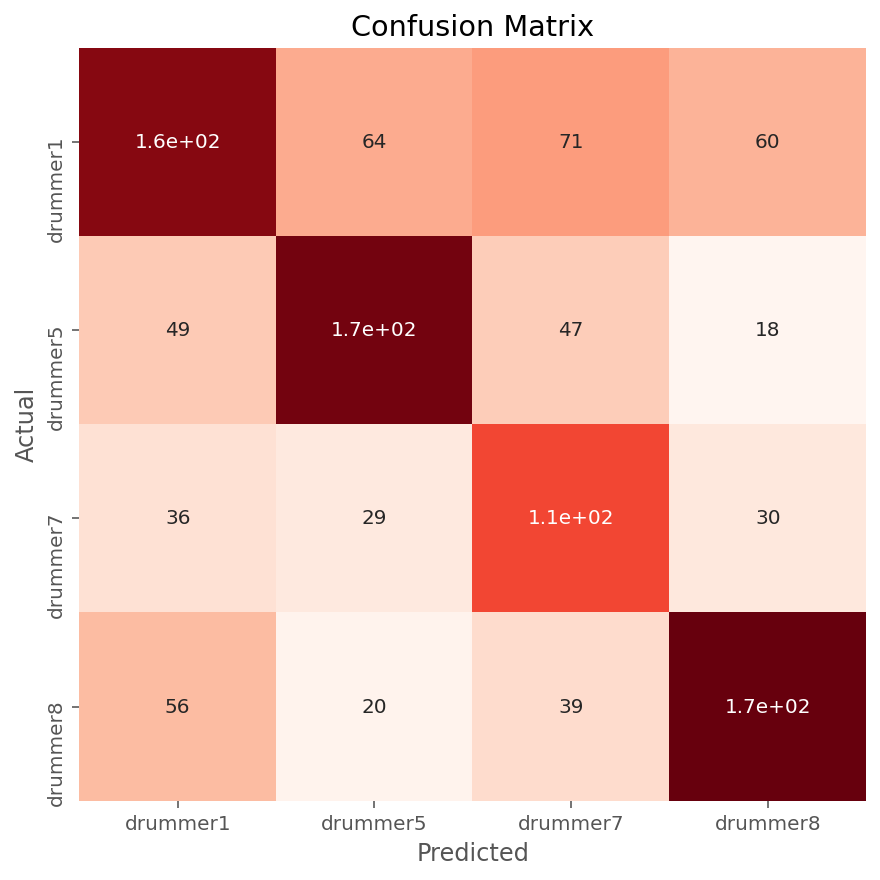

In [91]:
# y = list of all y values from dataset
classes = np.unique(y)
KNN_results(predictions_1, y_test, classes)
c_matrix(predictions_1, y_test, classes)

# K-fold CV

In [92]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

# list of ColumnTransformers setup earlier ..
cts = [ct_v0, ct_v1, ct_v2, ct_v3]


results = []
best_score = 0
best_info = ''

kf = KFold(n_splits=10, shuffle=True, random_state=27)

for idx, ct in enumerate(cts):
  print("\n_______________________________________________________")
  print("\n>>>> pipe #{}.. \n".format(idx))
  
  # Calculating error for K values between 1 and 20
  for next_k in range(1, 20):
    next_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier(next_k))])
    cv_results = cross_val_score(next_pipe, X, y, cv=kf, scoring="accuracy", n_jobs=-1 )
    results.append(cv_results)

    # print out put of this run.
    this_mean = cv_results.mean()
    this_run = "pipe #{}, k={}, mean:{}".format(idx, next_k, this_mean)
    print('\n\n ___ '+this_run)
    cv_results

    # check for best
    if this_mean > best_score:
      best_score = this_mean
      best_info = this_run
    
print("\n\nBest score was > {}".format(best_score))
print(best_info)




_______________________________________________________

>>>> pipe #0.. 



 ___ pipe #0, k=1, mean:0.49582530264666236


array([0.5035461 , 0.49023091, 0.4973357 , 0.5026643 , 0.51687389,
       0.5026643 , 0.5079929 , 0.46536412, 0.48490231, 0.48667851])



 ___ pipe #0, k=2, mean:0.4841077434715242


array([0.47340426, 0.4955595 , 0.5008881 , 0.47069272, 0.4991119 ,
       0.48845471, 0.4991119 , 0.44227353, 0.47246892, 0.4991119 ])



 ___ pipe #0, k=3, mean:0.5027553128503583


array([0.48758865, 0.5008881 , 0.52220249, 0.48845471, 0.52220249,
       0.51332149, 0.4920071 , 0.49023091, 0.5008881 , 0.50976909])



 ___ pipe #0, k=4, mean:0.5139437914918811


array([0.4964539 , 0.51332149, 0.52575488, 0.4920071 , 0.54529307,
       0.52397869, 0.52397869, 0.5079929 , 0.48490231, 0.52575488])



 ___ pipe #0, k=5, mean:0.5151836665280978


array([0.51595745, 0.51154529, 0.52930728, 0.4920071 , 0.52930728,
       0.5026643 , 0.52397869, 0.52575488, 0.49023091, 0.53108348])



 ___ pipe #0, k=6, mean:0.5160739704974617


array([0.5035461 , 0.52042629, 0.53108348, 0.48667851, 0.52575488,
       0.51332149, 0.51687389, 0.52397869, 0.5044405 , 0.53463588])



 ___ pipe #0, k=7, mean:0.5178445007117393


array([0.53546099, 0.52930728, 0.51865009, 0.47602131, 0.51154529,
       0.5062167 , 0.52753108, 0.52930728, 0.4973357 , 0.54706927])



 ___ pipe #0, k=8, mean:0.5093240996183062


array([0.50531915, 0.5044405 , 0.52575488, 0.47069272, 0.51332149,
       0.51332149, 0.5079929 , 0.53108348, 0.48134991, 0.53996448])



 ___ pipe #0, k=9, mean:0.5105683836589698


array([0.5       , 0.51687389, 0.52042629, 0.47957371, 0.52220249,
       0.5044405 , 0.52042629, 0.52220249, 0.48490231, 0.53463588])



 ___ pipe #0, k=10, mean:0.5157193605683836


array([0.5       , 0.5062167 , 0.52930728, 0.48667851, 0.52220249,
       0.51865009, 0.52042629, 0.54351687, 0.5008881 , 0.52930728])



 ___ pipe #0, k=11, mean:0.5134096720960406


array([0.5035461 , 0.52042629, 0.52042629, 0.47602131, 0.52930728,
       0.5079929 , 0.51154529, 0.53996448, 0.4973357 , 0.52753108])



 ___ pipe #0, k=12, mean:0.5107441139790635


array([0.5106383 , 0.51332149, 0.51154529, 0.47602131, 0.51865009,
       0.51687389, 0.5062167 , 0.52753108, 0.4973357 , 0.52930728])



 ___ pipe #0, k=13, mean:0.5050590176738092


array([0.5177305 , 0.51154529, 0.51332149, 0.46714032, 0.52575488,
       0.51154529, 0.5008881 , 0.5062167 , 0.48490231, 0.51154529])



 ___ pipe #0, k=14, mean:0.506836161394757


array([0.51241135, 0.52575488, 0.52042629, 0.47779751, 0.52220249,
       0.51687389, 0.4991119 , 0.5044405 , 0.48490231, 0.5044405 ])



 ___ pipe #0, k=15, mean:0.5093228399027498


array([0.51241135, 0.5008881 , 0.52397869, 0.47779751, 0.53463588,
       0.52575488, 0.4920071 , 0.51687389, 0.48845471, 0.52042629])



 ___ pipe #0, k=16, mean:0.5054189813940012


array([0.49113475, 0.5026643 , 0.52575488, 0.48667851, 0.53285968,
       0.52220249, 0.4955595 , 0.48845471, 0.47957371, 0.52930728])



 ___ pipe #0, k=17, mean:0.5041753272111157


array([0.4929078 , 0.4937833 , 0.51509769, 0.47957371, 0.52042629,
       0.51332149, 0.5008881 , 0.51865009, 0.48312611, 0.52397869])



 ___ pipe #0, k=18, mean:0.5059515261453963


array([0.4929078 , 0.5079929 , 0.52753108, 0.48312611, 0.52042629,
       0.5062167 , 0.48845471, 0.52220249, 0.48312611, 0.52753108])



 ___ pipe #0, k=19, mean:0.5000919592356046


array([0.4822695 , 0.4955595 , 0.50976909, 0.47602131, 0.52753108,
       0.5044405 , 0.4937833 , 0.51154529, 0.47246892, 0.52753108])


_______________________________________________________

>>>> pipe #1.. 



 ___ pipe #1, k=1, mean:0.5054139425317763


array([0.51950355, 0.5026643 , 0.48312611, 0.48845471, 0.54351687,
       0.52220249, 0.53285968, 0.47957371, 0.48845471, 0.4937833 ])



 ___ pipe #1, k=2, mean:0.5011516949472808


array([0.51595745, 0.48312611, 0.50976909, 0.47957371, 0.53285968,
       0.5079929 , 0.5044405 , 0.46891652, 0.5044405 , 0.5044405 ])



 ___ pipe #1, k=3, mean:0.5299235982515149


array([0.53014184, 0.50976909, 0.53108348, 0.5044405 , 0.58792185,
       0.53285968, 0.54706927, 0.5026643 , 0.53818828, 0.51509769])



 ___ pipe #1, k=4, mean:0.5308098081453207


array([0.54078014, 0.51154529, 0.53996448, 0.52575488, 0.61101243,
       0.51509769, 0.52753108, 0.5062167 , 0.51154529, 0.51865009])



 ___ pipe #1, k=5, mean:0.5340060214403588


array([0.54609929, 0.51154529, 0.54884547, 0.5044405 , 0.59325044,
       0.53463588, 0.53996448, 0.52575488, 0.5079929 , 0.52753108])



 ___ pipe #1, k=6, mean:0.5403990778882128


array([0.55319149, 0.53996448, 0.55239787, 0.50976909, 0.59680284,
       0.55239787, 0.53108348, 0.53641208, 0.51332149, 0.51865009])



 ___ pipe #1, k=7, mean:0.5453721199753095


array([0.55496454, 0.54351687, 0.55239787, 0.5079929 , 0.59502664,
       0.55239787, 0.53108348, 0.55595027, 0.53463588, 0.52575488])



 ___ pipe #1, k=8, mean:0.5460829144779109


array([0.55319149, 0.55062167, 0.56127886, 0.52042629, 0.58081705,
       0.53463588, 0.54351687, 0.55417407, 0.52930728, 0.53285968])



 ___ pipe #1, k=9, mean:0.552121360996687


array([0.55673759, 0.55772647, 0.56483126, 0.5062167 , 0.58259325,
       0.54529307, 0.54884547, 0.55950266, 0.56483126, 0.53463588])



 ___ pipe #1, k=10, mean:0.5483926029502538


array([0.54964539, 0.55062167, 0.57193606, 0.52575488, 0.58792185,
       0.52753108, 0.53641208, 0.55772647, 0.55595027, 0.52042629])



 ___ pipe #1, k=11, mean:0.5483944925235881


array([0.53900709, 0.55239787, 0.56483126, 0.51509769, 0.58259325,
       0.52930728, 0.55417407, 0.56305506, 0.55595027, 0.52753108])



 ___ pipe #1, k=12, mean:0.546970384087273


array([0.55673759, 0.56483126, 0.56483126, 0.51154529, 0.57371226,
       0.52220249, 0.53996448, 0.56127886, 0.54351687, 0.53108348])



 ___ pipe #1, k=13, mean:0.5451948150107706


array([0.55319149, 0.55062167, 0.54174067, 0.52220249, 0.58259325,
       0.51154529, 0.54174067, 0.56660746, 0.54884547, 0.53285968])



 ___ pipe #1, k=14, mean:0.5467952836249576


array([0.54255319, 0.54884547, 0.54706927, 0.53108348, 0.58969805,
       0.51687389, 0.53641208, 0.55595027, 0.55772647, 0.54174067])



 ___ pipe #1, k=15, mean:0.5404050615371049


array([0.51950355, 0.54174067, 0.54529307, 0.51154529, 0.58792185,
       0.52753108, 0.52575488, 0.55595027, 0.55950266, 0.52930728])



 ___ pipe #1, k=16, mean:0.5423547862892558


array([0.54255319, 0.54884547, 0.54529307, 0.51865009, 0.58081705,
       0.52930728, 0.52220249, 0.55239787, 0.55062167, 0.53285968])



 ___ pipe #1, k=17, mean:0.5361393497348299


array([0.53546099, 0.52753108, 0.53641208, 0.52042629, 0.59857904,
       0.51865009, 0.52397869, 0.53463588, 0.55062167, 0.51509769])



 ___ pipe #1, k=18, mean:0.538272678029301


array([0.5248227 , 0.54174067, 0.53463588, 0.53285968, 0.58436945,
       0.52397869, 0.53108348, 0.54174067, 0.54529307, 0.52220249])



 ___ pipe #1, k=19, mean:0.5377388735623496


array([0.53014184, 0.52220249, 0.54174067, 0.52753108, 0.58969805,
       0.52220249, 0.53818828, 0.54351687, 0.53996448, 0.52220249])


_______________________________________________________

>>>> pipe #2.. 



 ___ pipe #2, k=1, mean:0.5078993613242131


array([0.52659574, 0.4955595 , 0.4973357 , 0.4920071 , 0.55239787,
       0.51332149, 0.53463588, 0.47957371, 0.4955595 , 0.4920071 ])



 ___ pipe #2, k=2, mean:0.501329629769598


array([0.5141844 , 0.48667851, 0.5062167 , 0.48312611, 0.53463588,
       0.50976909, 0.5062167 , 0.46891652, 0.5079929 , 0.4955595 ])



 ___ pipe #2, k=3, mean:0.5276132799213937


array([0.53723404, 0.5062167 , 0.52575488, 0.5079929 , 0.57904085,
       0.52930728, 0.53996448, 0.4973357 , 0.53641208, 0.51687389])



 ___ pipe #2, k=4, mean:0.5308098081453207


array([0.54078014, 0.5079929 , 0.54351687, 0.52753108, 0.61101243,
       0.51865009, 0.52930728, 0.4991119 , 0.50976909, 0.52042629])



 ___ pipe #2, k=5, mean:0.5345382512628649


array([0.54964539, 0.50976909, 0.55239787, 0.5079929 , 0.59325044,
       0.53641208, 0.54174067, 0.52575488, 0.4991119 , 0.52930728])



 ___ pipe #2, k=6, mean:0.5398665331368178


array([0.55141844, 0.53818828, 0.55772647, 0.5079929 , 0.59325044,
       0.55239787, 0.53641208, 0.53818828, 0.50976909, 0.51332149])



 ___ pipe #2, k=7, mean:0.546260534371339


array([0.55319149, 0.54351687, 0.55417407, 0.51332149, 0.59502664,
       0.55239787, 0.53285968, 0.55239787, 0.53996448, 0.52575488])



 ___ pipe #2, k=8, mean:0.5443067155436301


array([0.55319149, 0.54706927, 0.55062167, 0.52042629, 0.57904085,
       0.53818828, 0.54529307, 0.55062167, 0.52397869, 0.53463588])



 ___ pipe #2, k=9, mean:0.5517651764231636


array([0.56205674, 0.56127886, 0.55595027, 0.50976909, 0.58081705,
       0.54529307, 0.54706927, 0.55950266, 0.55950266, 0.53641208])



 ___ pipe #2, k=10, mean:0.5492800725596161


array([0.55319149, 0.55239787, 0.57015986, 0.52397869, 0.59325044,
       0.52753108, 0.53285968, 0.55950266, 0.55772647, 0.52220249])



 ___ pipe #2, k=11, mean:0.5489270372749833


array([0.54078014, 0.55595027, 0.56660746, 0.51332149, 0.58259325,
       0.52753108, 0.55417407, 0.56305506, 0.55595027, 0.52930728])



 ___ pipe #2, k=12, mean:0.5473256238741293


array([0.55673759, 0.56305506, 0.56660746, 0.51509769, 0.57193606,
       0.52220249, 0.53641208, 0.56305506, 0.54529307, 0.53285968])



 ___ pipe #2, k=13, mean:0.5443070304725193


array([0.55141844, 0.54884547, 0.54351687, 0.51865009, 0.58614565,
       0.51509769, 0.53818828, 0.56305506, 0.54351687, 0.53463588])



 ___ pipe #2, k=14, mean:0.5455525742287393


array([0.53900709, 0.55062167, 0.54351687, 0.53108348, 0.58792185,
       0.51509769, 0.53285968, 0.55417407, 0.55595027, 0.54529307])



 ___ pipe #2, k=15, mean:0.5396939521056145


array([0.52304965, 0.54174067, 0.54174067, 0.51154529, 0.58614565,
       0.52930728, 0.52930728, 0.55417407, 0.55062167, 0.52930728])



 ___ pipe #2, k=16, mean:0.5409341420707203


array([0.54078014, 0.54884547, 0.54706927, 0.51687389, 0.58259325,
       0.52930728, 0.52042629, 0.55062167, 0.54529307, 0.52753108])



 ___ pipe #2, k=17, mean:0.5352506204099114


array([0.53900709, 0.51865009, 0.53463588, 0.51865009, 0.59680284,
       0.52042629, 0.52397869, 0.53641208, 0.54884547, 0.51509769])



 ___ pipe #2, k=18, mean:0.5366737840595593


array([0.52659574, 0.53996448, 0.53463588, 0.53108348, 0.58436945,
       0.52220249, 0.52930728, 0.54174067, 0.54174067, 0.51509769])



 ___ pipe #2, k=19, mean:0.5368504591663202


array([0.53191489, 0.51509769, 0.53818828, 0.52397869, 0.58969805,
       0.52397869, 0.53818828, 0.54529307, 0.53996448, 0.52220249])


_______________________________________________________

>>>> pipe #3.. 



 ___ pipe #3, k=1, mean:0.5078987314664349


array([0.53014184, 0.4937833 , 0.4991119 , 0.4920071 , 0.55417407,
       0.51509769, 0.52753108, 0.48667851, 0.4920071 , 0.48845471])



 ___ pipe #3, k=2, mean:0.5023944043434992


array([0.51950355, 0.48845471, 0.5062167 , 0.47779751, 0.53641208,
       0.51154529, 0.5062167 , 0.47069272, 0.5079929 , 0.4991119 ])



 ___ pipe #3, k=3, mean:0.5276132799213938


array([0.53723404, 0.5079929 , 0.52753108, 0.5079929 , 0.57904085,
       0.52930728, 0.53818828, 0.4973357 , 0.53641208, 0.51509769])



 ___ pipe #3, k=4, mean:0.5316969628257938


array([0.54609929, 0.51154529, 0.54351687, 0.52930728, 0.61101243,
       0.52220249, 0.52930728, 0.4973357 , 0.5062167 , 0.52042629])



 ___ pipe #3, k=5, mean:0.5370246148419687


array([0.55141844, 0.51332149, 0.55062167, 0.5079929 , 0.59325044,
       0.53996448, 0.54351687, 0.52753108, 0.5044405 , 0.53818828])



 ___ pipe #3, k=6, mean:0.5402217729236739


array([0.55141844, 0.54174067, 0.55595027, 0.5079929 , 0.59147425,
       0.55062167, 0.53285968, 0.53818828, 0.51154529, 0.52042629])



 ___ pipe #3, k=7, mean:0.5448392602950253


array([0.55496454, 0.54706927, 0.55595027, 0.51154529, 0.59147425,
       0.54884547, 0.53108348, 0.54884547, 0.53463588, 0.52397869])



 ___ pipe #3, k=8, mean:0.5444840205081691


array([0.55496454, 0.54706927, 0.54884547, 0.52042629, 0.57904085,
       0.53818828, 0.54351687, 0.55417407, 0.52397869, 0.53463588])



 ___ pipe #3, k=9, mean:0.5521201012811308


array([0.56382979, 0.56127886, 0.56305506, 0.5079929 , 0.57904085,
       0.54529307, 0.54706927, 0.55950266, 0.55950266, 0.53463588])



 ___ pipe #3, k=10, mean:0.549102452666188


array([0.55319149, 0.55239787, 0.57015986, 0.52220249, 0.59502664,
       0.52397869, 0.53285968, 0.55772647, 0.56127886, 0.52220249])



 ___ pipe #3, k=11, mean:0.5496372019198065


array([0.54255319, 0.55595027, 0.57015986, 0.51332149, 0.58614565,
       0.52753108, 0.55239787, 0.56305506, 0.55772647, 0.52753108])



 ___ pipe #3, k=12, mean:0.5476811785898745


array([0.55496454, 0.56127886, 0.56483126, 0.51509769, 0.57193606,
       0.52575488, 0.54174067, 0.56305506, 0.54706927, 0.53108348])



 ___ pipe #3, k=13, mean:0.5443067155436302


array([0.55319149, 0.54884547, 0.54529307, 0.51865009, 0.58259325,
       0.51865009, 0.53463588, 0.56305506, 0.54174067, 0.53641208])



 ___ pipe #3, k=14, mean:0.5462627388735624


array([0.54078014, 0.55062167, 0.54529307, 0.53108348, 0.59147425,
       0.51687389, 0.53108348, 0.55417407, 0.55772647, 0.54351687])



 ___ pipe #3, k=15, mean:0.5402264968570096


array([0.5248227 , 0.54174067, 0.54174067, 0.51154529, 0.58614565,
       0.52930728, 0.52930728, 0.55772647, 0.55062167, 0.52930728])



 ___ pipe #3, k=16, mean:0.5405789022838643


array([0.54078014, 0.55062167, 0.54529307, 0.51332149, 0.58259325,
       0.52930728, 0.52042629, 0.55062167, 0.54351687, 0.52930728])



 ___ pipe #3, k=17, mean:0.5352506204099114


array([0.53900709, 0.52042629, 0.53463588, 0.51865009, 0.59502664,
       0.52220249, 0.52042629, 0.53818828, 0.54884547, 0.51509769])



 ___ pipe #3, k=18, mean:0.5361406094503861


array([0.52836879, 0.53996448, 0.53463588, 0.53108348, 0.58436945,
       0.52042629, 0.52753108, 0.54351687, 0.53818828, 0.51332149])



 ___ pipe #3, k=19, mean:0.53596235969918


array([0.53191489, 0.51154529, 0.53818828, 0.52397869, 0.58969805,
       0.52397869, 0.53641208, 0.54351687, 0.53818828, 0.52220249])



Best score was > 0.552121360996687
pipe #1, k=9, mean:0.552121360996687


# GridSearch

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

NOTE: tested initially on this song filter ..
* style_filter = "3_soul-groove3"   

.. where was able to get 0.72 score!!

In [51]:
from  sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
sklearn.__version__  # should be 0.23.2


'0.23.2'

Quick review of stats of the data we're about to use in the model search...

In [218]:
X.describe()
pd.DataFrame(y).describe()
print('Drummers: {}'.format(np.unique(y)))
print('Beat positions: {}'.format(np.unique(X.bar_beat_number)))

,velocity,beat_offset,bar_beat_number
count,835.000000,835.000000,835.000000
mean,83.989222,-7.491018,7.843114
std,33.096235,11.858411,4.397848
min,6.000000,-50.000000,1.000000
25%,53.000000,-14.000000,5.000000
50%,88.000000,-6.000000,8.000000
75%,112.000000,1.000000,12.000000
max,127.000000,25.000000,16.000000


,0
count,835
unique,4
top,drummer8
freq,216


Drummers: ['drummer1' 'drummer5' 'drummer7' 'drummer8']
Beat positions: [ 1  3  5  6  7  8  9 11 12 13 14 15 16]


In [219]:


# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3]


param_grid = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
     knn__p=[1, 2, 5], # knn distance functions to test
     prep=grid_cts # list of ColTransformers to search
)

my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid, cv=10, verbose=1)

print('\n>>>>FITTING ....\n')
grid_search.fit(X,y)

# capture results in df
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
# display(results_df)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)





>>>>FITTING ....

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2280 out of 2280 | elapsed:   57.1s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_mm_1',
                                                                         MinMaxScaler(),
                                                                         [1,
                                                                          2]),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         [0])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'knn__p': [1, 2...
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_mm_1',
                                                                   MinMaxScaler(),
                                                                   [1]),
                                                                  ('t_scaler_mm_2',
                                                                   MinMaxScaler(feature_range=(-0.5,
                                                                                               0.5)),
                                                                   [2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0])]),
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_mm_1',
                                                                   MinMaxScaler(),
                                                                   [1, 2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0])])]},
             verbose=1)


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=6, p=5))])


___BEST SCORE



0.6922834193918531


___BEST PARAMS



{'knn__n_neighbors': 6,
 'knn__p': 5,
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),
                                 ('t_one_hot', OneHotEncoder(drop='first'),
                                  [0])])}

In [220]:
grid_results = pd.DataFrame(grid_search.cv_results_['params'])
grid_results['test_score'] = grid_search.cv_results_['mean_test_score']
grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results.head()

,knn__n_neighbors,knn__p,prep,test_score,metric
0,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_robust',\n RobustScaler(quantile_range=(25, 75)),\n [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.616681,Manhattan
1,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),\n ('t_scaler_mm_2',\n MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),\n ('t_one_hot', OneHotEncoder(drop='first'), [0]),\n ('t_one_hot_beat_pos',\n OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,\n 8, 9, 10, 11, 12,\n 13, 14, 15, 16]],\n drop='first'),\n [3])])",0.637034,Manhattan
2,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),\n ('t_scaler_mm_2',\n MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.634653,Manhattan
3,1,1,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.633477,Manhattan
4,1,2,"ColumnTransformer(remainder='passthrough', sparse_threshold=0,\n transformers=[('t_scaler_robust',\n RobustScaler(quantile_range=(25, 75)),\n [1, 2]),\n ('t_one_hot', OneHotEncoder(drop='first'),\n [0])])",0.629848,Euclidean


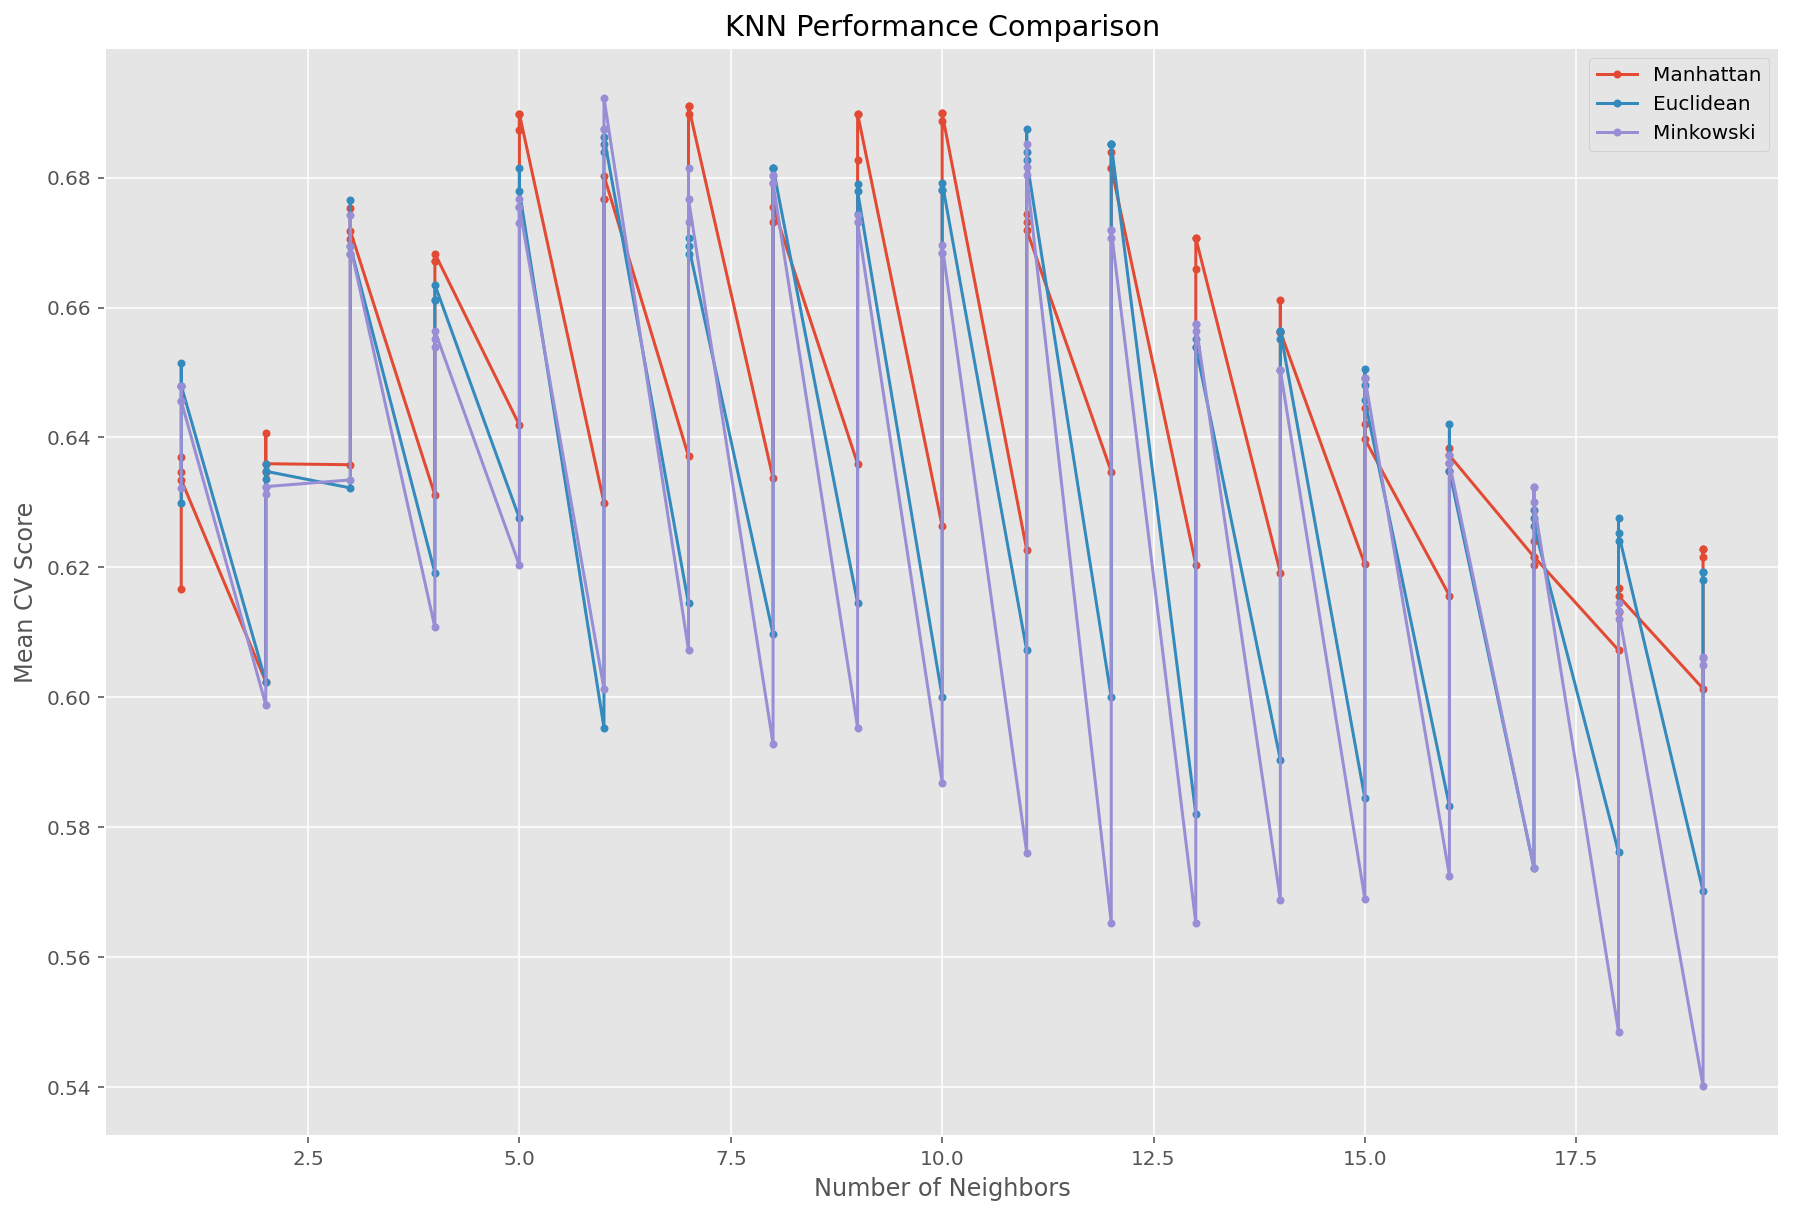

In [221]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    _ = plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
_ = plt.legend()
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel("Mean CV Score")
_ = plt.title("KNN Performance Comparison")
plt.show()